In [ ]:
"""
Created on Fri Nov  5 16:05:42 2021

@author: xiangli
@ID: xiangl6


###Q1 Data ETL (please check it in my code)

###Q2 converting the utterances into a sparse bag-of-words(BOW) representation. (please check it in my code)

###Q3 What do you think might be a shortcoming of the previous representation of utterance features? 
There are many words which are not necessarily adding much value to the classifier.
For instance, words like ‘a’, ‘the’, ‘is’, ‘and’
We need to remove such stop words

###Q4 Normalization (please check it in my code)
###Q5 SGD classifier
Train result:
Accuary on train data is:  89.42%
F1 score : [0.89186272, 0.89443378, 0.8830822, 0.90789735]
Confusion matrix : 
[[2066   83  109   71]
 [  87 2097   94   68]
 [  96  104 2315  119]
 [  55   59   91 2282]]
f1 score using SGD classifier is : 89.43%

Test result:
Accuary on test data is:  100.0%
F1 score : [0.9972752, 1, 0.99742931, 1]
Confusion matrix : 
[[183   0   0   0]
 [  0 187   0   0]
 [  1   0 194   0]
 [  0   0   0 155]]
f1 score using SGD classifier is : 99.87%

###Q6 pre-trained word embeddings and MLP classifier
Train result:
Accuary on test data is:  98.47%
F1 score : [0.98635478, 0.98464819, 0.98558969, 0.98223907]
Confusion matrix : 
[[2277   15   13   24]
 [   5 2309   17   15]
 [   3    8 2599   24]
 [   3   12   11 2461]]
f1 score using SGD classifier is : 98.47%

Test result:
Accuary on test data is:  99.86%
F1 score : [0.9972752, 1, 0.99742931, 1]
Confusion matrix : 
[[183   0   0   0]
 [  0 187   0   0]
 [  1   0 194   0]
 [  0   0   0 155]]
f1 score using SGD classifier is : 99.87%

###Q7 Read the paper at https://arxiv.org/pdf/1811.00207.pdf and answer the following questions:

(1) What does this paper mean by "fine-tuning" results? How might you use such fine-tuning in building an empathetic chatbot?
I think "fine-tuning" means training of the pre-trained model on target task here.
I will take more conversion data to train existing model in order to build up an empathetic chatbot.

(2) What properties of the transformer architecture make it well suited for this application?
Transformer models make the models seem more empathetic. It can read speaker's input and generate more empathetic feedback.
It is trained to minimize the negative log-likelihood of the target sequence y.

(3) Explain the metrics used to evaluate performance in Table 1 (P@1,100, AVG-BLEU, and PPL).

P@1,100: precision retrieving the correct test candi- date out of 100 test candidates.

AVG-BLEU: Average bilingual evaluation understudy is an algorithm for evaluating the quality of text which has been machine-translated from one natural language to another.
BLEU's output is always a number between 0 and 1. This value indicates how similar the candidate text is to the reference texts, with values closer to 1 representing more similar texts.

PPL: perplexity. Perplexity is a measurement of how well a probability distribution or probability model predicts a sample. 

(4) Which of the metrics do you think provides the best measure of performance of empathic systems and why?
I think AVG-BLEU can provide best measure of performance of empathic systems.
Because AVG-BLEU can be used in all models so we could compare each model's performace via AVG-BLEU.
While P@1,100 only measures 100 test candidates, it might have selecting biases.
PPL gives the probability distribution, which is different from model performance.

(5) Based on Tables 1 and 2, and your reading of the paper, what do you think would help the system get to human-level performance?
I think fine-tuning models using more qualified labeled data is a good way to help improve the system.

"""

In [2]:
pip install PCA
#pip install xgboost
#pip install xgboost --no-binary xgboost -v

SyntaxError: invalid syntax (<ipython-input-2-b04bd9fe079b>, line 1)

In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Nov  5 16:05:42 2021

@author: xiangli
"""

import os
import re

import pandas as pd
import numpy as np

import gensim
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords 
import nltk
nltk.download('punkt')

from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter, OrderedDict
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix


from itertools import compress
import collections

from gensim.models.word2vec import Word2Vec
from nltk.tokenize import word_tokenize
import seaborn as sns
import matplotlib.pyplot as plt
#import xgboost as xgb
from sklearn.decomposition import PCA

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/xiangli/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/xiangli/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
# Process data - filter out irrelevant sentiments
train = pd.read_csv('/Users/xiangli/Desktop/95891 AI/HW4/train.csv', error_bad_lines=False)
train['utterance']=train['utterance'].str.lower()
train['utterance']=train['utterance'].str.replace('_comma_', '')
train['utterance']=train['utterance'].str.replace('.', '')
train['utterance']=train['utterance'].str.replace('!', '')
train['utterance']=train['utterance'].str.replace('?', '')

valid = pd.read_csv('/Users/xiangli/Desktop/95891 AI/HW4/valid.csv', error_bad_lines=False)
valid['utterance']=valid['utterance'].str.lower()
valid['utterance']=valid['utterance'].str.replace('_comma_', '')
valid['utterance']=valid['utterance'].str.replace('.', '')
valid['utterance']=valid['utterance'].str.replace('!', '')
valid['utterance']=valid['utterance'].str.replace('?', '')

test = pd.read_csv('/Users/xiangli/Desktop/95891 AI/HW4/test.csv', error_bad_lines=False)
test['utterance']=test['utterance'].str.lower()
test['utterance']=test['utterance'].str.replace('_comma_', '')
test['utterance']=test['utterance'].str.replace('.', '')
test['utterance']=test['utterance'].str.replace('!', '')
test['utterance']=test['utterance'].str.replace('?', '')

sentiments = {'sad', 'jealous', 'joyful', 'terrified'}
train = train[train.context.isin(sentiments)]
train = train[['context','utterance']]
train['utterance_split']=train['utterance'].str.split()

valid = valid[valid.context.isin(sentiments)]
valid = valid[['context','utterance']]
valid['utterance_split']=valid['utterance'].str.split()

test = test[test.context.isin(sentiments)]
test = test[['context','utterance']]
test['utterance_split']=test['utterance'].str.split()

b'Skipping line 2355: expected 8 fields, saw 10\nSkipping line 36628: expected 8 fields, saw 12\nSkipping line 49433: expected 8 fields, saw 10\nSkipping line 56957: expected 8 fields, saw 10\nSkipping line 65019: expected 8 fields, saw 10\n'
b'Skipping line 3: expected 8 fields, saw 9\nSkipping line 5: expected 8 fields, saw 9\nSkipping line 8: expected 8 fields, saw 9\nSkipping line 10: expected 8 fields, saw 9\nSkipping line 12: expected 8 fields, saw 9\nSkipping line 14: expected 8 fields, saw 9\nSkipping line 16: expected 8 fields, saw 9\nSkipping line 18: expected 8 fields, saw 9\nSkipping line 20: expected 8 fields, saw 9\nSkipping line 22: expected 8 fields, saw 9\nSkipping line 24: expected 8 fields, saw 9\nSkipping line 26: expected 8 fields, saw 9\nSkipping line 28: expected 8 fields, saw 9\nSkipping line 30: expected 8 fields, saw 9\nSkipping line 32: expected 8 fields, saw 9\nSkipping line 34: expected 8 fields, saw 9\nSkipping line 37: expected 8 fields, saw 9\nSkipping l

In [5]:
# create bag of words
bag_words = set()
for r in train['utterance_split']:
    for elements in r:
        bag_words.add(elements.lower())

train_count_vectorizer = DictVectorizer()
X = train_count_vectorizer.fit_transform(Counter(row['utterance_split']) for _, row in train.iterrows())
X_v = train_count_vectorizer.fit_transform(Counter(row['utterance_split']) for _, row in valid.iterrows())
X_te = train_count_vectorizer.fit_transform(Counter(row['utterance_split']) for _, row in test.iterrows())

# check metrics
print (X.shape)
print (X.A)
print (X.min())
print (X.max())

# remove stop words, NLTK
stopwords_list= list(set(stopwords.words('english')))
stopwords_list.extend(['comma', ''])

def filter_nltk(splitlist):
    nltk=[]
    for i in splitlist:
        if i not in stopwords_list:
            nltk.append(i)
    return list(set(nltk))
train['utterance_nltk'] = train['utterance_split'].apply(filter_nltk)
valid['utterance_nltk'] = valid['utterance_split'].apply(filter_nltk)
test['utterance_nltk'] = test['utterance_split'].apply(filter_nltk)

train_data_stop_removed = bag_words - set(stopwords_list)
X_nltk = train_count_vectorizer.fit_transform(Counter(row['utterance_nltk']) for _, row in train.iterrows())
X_nltk_v = train_count_vectorizer.fit_transform(Counter(row['utterance_nltk']) for _, row in valid.iterrows())
X_nltk_te = train_count_vectorizer.fit_transform(Counter(row['utterance_nltk']) for _, row in test.iterrows())


# check nltk metrics
print (X_nltk.shape)
print (X_nltk.A)
print (X_nltk.min())
print (X_nltk.max())


# Normalization
train_tfidf_transformer = TfidfTransformer(smooth_idf=True,use_idf=True)
train_embedding_tfidf_transformer = train_tfidf_transformer.fit_transform(X_nltk)

valid_tfidf_transformer = TfidfTransformer(smooth_idf=True,use_idf=True)
valid_embedding_tfidf_transformer = train_tfidf_transformer.fit_transform(X_nltk_v)

test_tfidf_transformer = TfidfTransformer(smooth_idf=True,use_idf=True)
test_embedding_tfidf_transformer = train_tfidf_transformer.fit_transform(X_nltk_te)

# check normalization metrics
print(train_embedding_tfidf_transformer)
print (train_embedding_tfidf_transformer.shape)
print (train_embedding_tfidf_transformer.A)
print (train_embedding_tfidf_transformer.min())
print (train_embedding_tfidf_transformer.max())

# build a SGD classifer
X_train = train_embedding_tfidf_transformer
y_train = train['context']
clf = make_pipeline(StandardScaler(with_mean=False),SGDClassifier(max_iter=1000, tol=1e-3))
clf.fit(X_train, y_train)

(9796, 11021)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
0.0
684.0
(9796, 10870)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
0.0
1.0
  (0, 10155)	0.34803980855056965
  (0, 9450)	0.34803980855056965
  (0, 6841)	0.3754427499298468
  (0, 6619)	0.21491684011944628
  (0, 6618)	0.19732785411176998
  (0, 6480)	0.2806441480787111
  (0, 6398)	0.15267648396095054
  (0, 6082)	0.20475479649204226
  (0, 5920)	0.34803980855056965
  (0, 3541)	0.32063686717129253
  (0, 1362)	0.3594130568135096
  (0, 573)	0.1858455462275753
  (1, 7888)	0.7702164485064916
  (1, 7144)	0.6377825824291905
  (2, 9803)	0.43325378607798326
  (2, 9802)	0.40890973161279903
  (2, 7888)	0.3713347783779235
  (2, 6398)	0.18404357734693724
  (2, 3567)	0.25219669505260417
  (2, 3160)	0.21146329834210598
  (2, 215

Pipeline(steps=[('standardscaler', StandardScaler(with_mean=False)),
                ('sgdclassifier', SGDClassifier())])

In [6]:
# make prediction
train_predict = clf.predict(X_train)
y_train = y_train.values
score=0
for i in range(len(train_predict)):
    if train_predict[i]==y_train[i]:
        score=score+1
    else:
        score=score
accuracy = score/len(train_predict)*100
print("Accuary on train data is: ", accuracy)

F1_score_train = f1_score(y_train, train_predict, average=None)
print('F1 score :', F1_score_train)

confusion_matrix_train = confusion_matrix(y_train, train_predict)
print('Confusion matrix :',confusion_matrix_train)

print('f1 score using SGD classifier is :',np.mean(F1_score_train))

# make prediction on test data
X_test = test_embedding_tfidf_transformer
y_test= test['context']
clf = make_pipeline(StandardScaler(with_mean=False),SGDClassifier(max_iter=1000, tol=1e-3))
clf.fit(X_test, y_test)
test_predict = clf.predict(X_test)
y_test = y_test.values
score_test=0
for i in range(len(test_predict)):
    if test_predict[i]==test_predict[i]:
        score_test=score_test+1
    else:
        score_test=score_test
accuracy_test = score_test/len(test_predict)*100
print("Accuary on test data is: ", accuracy_test)

F1_score_test = f1_score(y_test, test_predict, average=None)
print('F1 score :', F1_score_test)

confusion_matrix_test = confusion_matrix(y_test, test_predict)
print('Confusion matrix :',confusion_matrix_test)

print('f1 score using SGD classifier is :',np.mean(F1_score_test))

Accuary on train data is:  89.16904859126174
F1 score : [0.88797932 0.89215061 0.87808555 0.90934844]
Confusion matrix : [[2061   95  112   61]
 [  86 2097  117   46]
 [ 104   99 2330  101]
 [  62   64  114 2247]]
f1 score using SGD classifier is : 0.8918909787073784
Accuary on test data is:  100.0
F1 score : [0.9972752  1.         0.99742931 1.        ]
Confusion matrix : [[183   0   0   0]
 [  0 187   0   0]
 [  1   0 194   0]
 [  0   0   0 155]]
f1 score using SGD classifier is : 0.9986761275680673


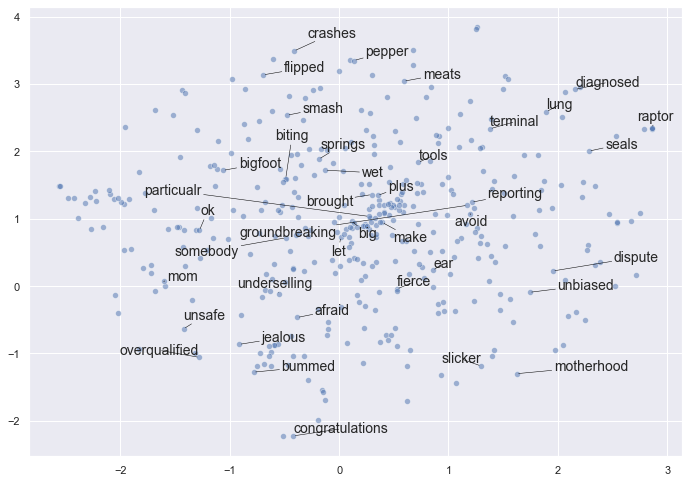

2513 docs removed
0 docs removed


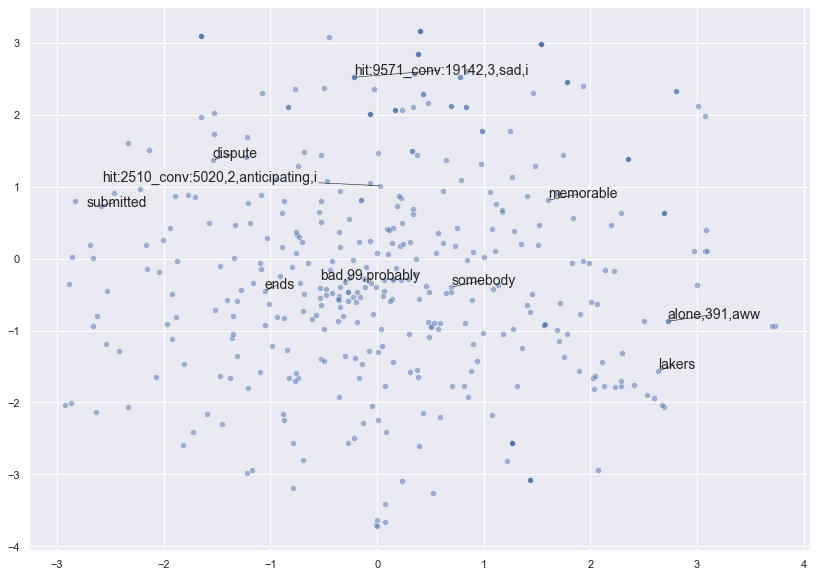

In [7]:
# build a classifier using pre-trained word embeddings like word2vec
# Loading the pretrained word2vec model from Google
# download the model here: https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
model = gensim.models.KeyedVectors.load_word2vec_format('/Users/xiangli/Desktop/95891 AI/HW4/GoogleNews-vectors-negative300.bin', binary=True)
train_data_stop_removed = set()
for r in train['utterance_nltk']:
    for elements in r:
        train_data_stop_removed.add(elements.lower())
train_data_stop_removed = list(train_data_stop_removed)
big_train_string = ' '.join(train_data_stop_removed)
# Tokenize the string into words
train_tokens = word_tokenize(big_train_string)
train_y = np.array(train['context'])
# Remove non-alphabetic tokens, such as punctuation
train_tokens = [word.lower() for word in train_tokens if word.isalpha()]
train_tokens[:10]
# Check dimension of word vectors
model.vector_size

# Filter the list of vectors to include only those that Word2Vec has a vector for
vector_list = [model[word] for word in train_tokens if word in model.index_to_key]

# Create a list of the words corresponding to these vectors
words_filtered = [word for word in train_tokens if word in model.index_to_key]

# Zip the words together with their vector representations
word_vec_zip = zip(words_filtered, vector_list)

# Cast to a dict so we can turn it into a DataFrame
word_vec_dict = dict(word_vec_zip)
df = pd.DataFrame.from_dict(word_vec_dict, orient='index')
# df.head(3)
from sklearn.manifold import TSNE

# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)

# Use only 400 rows to shorten processing time
tsne_df = tsne.fit_transform(df[:400])
sns.set()
# Initialize figure
fig, ax = plt.subplots(figsize = (11.7, 8.27))
sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha = 0.5)

# Import adjustText, initialize list of texts
from adjustText import adjust_text
texts = []
words_to_plot = list(np.arange(0, 400, 10))

# Append words to list
for word in words_to_plot:
    texts.append(plt.text(tsne_df[word, 0], tsne_df[word, 1], df.index[word], fontsize = 14))
    
# Plot text using adjust_text (because overlapping text is hard to read)
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.show()

def document_vector(word2vec_model, doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in model.index_to_key]
    return np.mean(model[doc], axis=0)

# Our earlier preprocessing was done when we were dealing only with word vectors
# Here, we need each document to remain a document 
def preprocess(text):
    text = text.lower()
    doc = word_tokenize(text)
    doc = [word for word in doc if word not in stopwords_list]
    doc = [word for word in doc if word.isalpha()] 
    return doc

# Function that will help us drop documents that have no word vectors in word2vec
def has_vector_representation(word2vec_model, doc):
    """check if at least one word of the document is in the
    word2vec dictionary"""
    return not all(word not in word2vec_model.index_to_key for word in doc)

# Filter out documents
def filter_docs(corpus, texts, condition_on_doc):
    """
    Filter corpus and texts given the function condition_on_doc which takes a doc. The document doc is kept if condition_on_doc(doc) is true.
    """
    number_of_docs = len(corpus)

    if texts is not None:
        texts = [text for (text, doc) in zip(texts, corpus)
                 if condition_on_doc(doc)]

    corpus = [doc for doc in corpus if condition_on_doc(doc)]

    print("{} docs removed".format(number_of_docs - len(corpus)))

    return (corpus, texts)

# Preprocess the corpus
corpus = [preprocess(word) for word in train_data_stop_removed]

# Remove docs that don't include any words in W2V's vocab
corpus, train_data_stop_removed= filter_docs(corpus, train_data_stop_removed, lambda doc: has_vector_representation(model, doc))

# Filter out any empty docs
corpus, train_data_stop_removed = filter_docs(corpus, train_data_stop_removed, lambda doc: (len(doc) != 0))
x = []
for doc in corpus: # append the vector for each document
    x.append(document_vector(model, doc))

X = np.array(x) # list to array

# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)

# Again use only 400 rows to shorten processing time
tsne_df = tsne.fit_transform(X[:400])
fig, ax = plt.subplots(figsize = (14, 10))
sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha = 0.5)

from adjustText import adjust_text
texts = []
titles_to_plot = list(np.arange(0, 400, 40)) # plots every 40th title in first 400 titles

# Append words to list
for title in titles_to_plot:
    texts.append(plt.text(tsne_df[title, 0], tsne_df[title, 1], train_data_stop_removed[title], fontsize = 14))
    
# Plot text using adjust_text
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.show()

In [32]:
pca = PCA(n_components=15, random_state=10)

reduced_vecs = pca.fit_transform(x)
df_w_vectors = pd.DataFrame(reduced_vecs)

df_w_vectors['Title'] = train_data_stop_removed
# Use pd.concat to match original titles with their vectors
main_w_vectors = pd.concat((df_w_vectors, train), axis=1)

# Get rid of vectors that couldn't be matched with the main_df
main_w_vectors.dropna(axis=0, inplace=True)

from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# MLPC classifier prediction on train data 
clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)
train_predict = clf.predict(X_train)
print("Accuary on test data is: ", clf.score(X_train, y_train)*100)
F1_score_train = f1_score(y_train, train_predict,average=None)
print('F1 score :', F1_score_train)
confusion_matrix_train= confusion_matrix(y_train, train_predict)
print('Confusion matrix :',confusion_matrix_train)
print('f1 score using SGD classifier is :',np.mean(F1_score_train))

# MLPC classifier prediction on test data 
clf = MLPClassifier(random_state=1, max_iter=300).fit(X_test, y_test)
test_predict = clf.predict(X_test)
print("Accuary on test data is: ", clf.score(X_test, y_test)*100)
F1_score_test = f1_score(y_test, test_predict,average=None)
print('F1 score :', F1_score_test)
confusion_matrix_train= confusion_matrix(y_test, test_predict)
print('Confusion matrix :',confusion_matrix_test)
print('f1 score using SGD classifier is :',np.mean(F1_score_test))

/Users/xiangli/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuary on test data is:  98.46876276031034
F1 score : [0.98635478 0.98464819 0.98558969 0.98223907]
Confusion matrix : [[2277   15   13   24]
 [   5 2309   17   15]
 [   3    8 2599   24]
 [   3   12   11 2461]]
f1 score using SGD classifier is : 0.9847079306868072
Accuary on test data is:  99.86111111111111
F1 score : [0.9972752  1.         0.99742931 1.        ]
Confusion matrix : [[183   0   0   0]
 [  0 187   0   0]
 [  1   0 194   0]
 [  0   0   0 155]]
f1 score using SGD classifier is : 0.9986761275680673
